Импорт библиотек

In [1]:
from typing import Tuple, List
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split, TensorDataset, DataLoader

Загрузка датасета

In [2]:
def load_and_preprocess_data(file_path: str) -> torch.Tensor:
    """Load data from a CSV file and preprocess it."""

    data = pd.read_csv(file_path)
    data = data[data['Value'] != "Page not found"]

    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    data['Value'] = (data['Value'].astype(float) - data['Value'].astype(float).min()) / (data['Value'].astype(float).max() - data['Value'].astype(float).min())

    return torch.tensor(data['Value'].values, dtype=torch.float32)

Разбиение датасета на тренировочную, валидационную и тестировочную выборки

In [3]:
def split_data(all_data: torch.Tensor, train_ratio: float = 0.8, val_ratio: float = 0.1) -> Tuple[
    torch.utils.data.Dataset, torch.utils.data.Dataset, torch.utils.data.Dataset]:
    """
    Split data into training, validation, and test sets.

    Args:
    - all_data (torch.Tensor): The entire dataset.
    - train_ratio (float): Proportion of data for training.
    - val_ratio (float): Proportion of data for validation.

    Returns:
    - Tuple[torch.utils.data.Dataset, torch.utils.data.Dataset, torch.utils.data.Dataset]: 
      Tuple of datasets (train, validation, test).
    """

    train_size = int(train_ratio * len(all_data))
    val_size = int(val_ratio * len(all_data))
    test_size = len(all_data) - train_size - val_size

    train_data, valtest_data = random_split(all_data, [train_size, val_size + test_size])
    val_data, test_data = random_split(valtest_data, [val_size, test_size])

    return train_data, val_data, test_data

Разбиение выборок на последовательности

In [4]:
def create_sequence_data(data: torch.Tensor, seq_length: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Create sequences from input data.

    Args:
    - data (torch.Tensor): Input data.
    - seq_length (int): Length of the sequences.

    Returns:
    - Tuple[torch.Tensor, torch.Tensor]: Sequences and labels.
    """

    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    sequences_tensor = torch.stack(sequences).unsqueeze(-1)
    labels_tensor = torch.stack(labels)

    return sequences_tensor, labels_tensor

Тренировка модели

In [5]:
def train_model(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer,
                train_loader: DataLoader, val_loader: DataLoader, num_epochs: int) -> Tuple[List[float], List[float]]:
    """
    Train the model.

    Args:
    - model (nn.Module): The model to be trained.
    - criterion (nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - num_epochs (int): Number of epochs for training.

    Returns:
    - Tuple[List[float], List[float]]: Training and validation losses.
    """

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    return train_losses, val_losses

Класс модели для решения задачи прогнозирования временных рядов

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        """
        LSTM model initialization.

        Args:
        - input_size (int): Dimension of input features.
        - hidden_size (int): Dimension of hidden state.
        - num_layers (int): Number of LSTM layers.
        - output_size (int): Dimension of output.
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the LSTM model.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Построение графиков

In [7]:
def show_graphs(results: List[dict], num_epochs: int) -> None:
    """
    Show training and validation loss graphs.

    Args:
    - results (List[dict]): List of dictionaries containing experiment results.
    - num_epochs (int): Number of epochs used in training.
    """
    num_plots = len(results)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 3 * num_rows))

    for i, result in enumerate(results, start=1):
        plt.subplot(num_rows, num_cols, i)
        plt.plot(range(1, num_epochs + 1), result['train_losses'], label='Training Loss')
        plt.plot(range(1, num_epochs + 1), result['val_losses'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"LR={result['lr']}, BS={result['batch_size']}")
        plt.legend()

    plt.tight_layout()
    plt.show()

Методы оценки и тестирования модели

In [8]:
def evaluate_model(model: nn.Module, data_loader: DataLoader, criterion: nn.Module) -> float:
    """
    Evaluate the model on the test set.

    Args:
    - model (nn.Module): The trained model.
    - data_loader (DataLoader): DataLoader for test data.
    - criterion (nn.Module): The loss function.

    Returns:
    - float: Test loss.
    """
    total_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
    return (total_loss / len(data_loader.dataset))

def test_model(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Tests the model on test data.

    Parameters:
    - model (nn.Module): Model.
    - test_loader (DataLoader): DataLoader for test data.

    Returns:
    - float: Loss value.
    """
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
    return (total_loss / len(test_loader.dataset))

Выполнение всех требуемых задач

Training with learning rate: 0.001, batch size: 32


c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10: Train Loss: 0.038024, Val Loss: 0.028812
Epoch 2/10: Train Loss: 0.031160, Val Loss: 0.029357
Epoch 3/10: Train Loss: 0.031168, Val Loss: 0.028977
Epoch 4/10: Train Loss: 0.031066, Val Loss: 0.028901
Epoch 5/10: Train Loss: 0.031027, Val Loss: 0.028935
Epoch 6/10: Train Loss: 0.031146, Val Loss: 0.029434
Epoch 7/10: Train Loss: 0.031057, Val Loss: 0.028966
Epoch 8/10: Train Loss: 0.031325, Val Loss: 0.030186
Epoch 9/10: Train Loss: 0.031057, Val Loss: 0.029187
Epoch 10/10: Train Loss: 0.030978, Val Loss: 0.029017
Training completed.

Training with learning rate: 0.001, batch size: 64


c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10: Train Loss: 0.045808, Val Loss: 0.028891
Epoch 2/10: Train Loss: 0.030932, Val Loss: 0.029284
Epoch 3/10: Train Loss: 0.031008, Val Loss: 0.029192
Epoch 4/10: Train Loss: 0.031047, Val Loss: 0.028922
Epoch 5/10: Train Loss: 0.031082, Val Loss: 0.028930
Epoch 6/10: Train Loss: 0.031122, Val Loss: 0.029309
Epoch 7/10: Train Loss: 0.031091, Val Loss: 0.029254
Epoch 8/10: Train Loss: 0.031019, Val Loss: 0.028954
Epoch 9/10: Train Loss: 0.031026, Val Loss: 0.029303
Epoch 10/10: Train Loss: 0.031062, Val Loss: 0.029583
Training completed.

Training with learning rate: 0.001, batch size: 128
Epoch 1/10: Train Loss: 0.057858, Val Loss: 0.030430


c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([117])) that is different to the input size (torch.Size([117, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10: Train Loss: 0.031310, Val Loss: 0.028973
Epoch 3/10: Train Loss: 0.030925, Val Loss: 0.028891
Epoch 4/10: Train Loss: 0.030914, Val Loss: 0.028893
Epoch 5/10: Train Loss: 0.030938, Val Loss: 0.028919
Epoch 6/10: Train Loss: 0.030947, Val Loss: 0.028989
Epoch 7/10: Train Loss: 0.030904, Val Loss: 0.029156
Epoch 8/10: Train Loss: 0.030988, Val Loss: 0.028917
Epoch 9/10: Train Loss: 0.030993, Val Loss: 0.028990
Epoch 10/10: Train Loss: 0.030915, Val Loss: 0.028943
Training completed.

Training with learning rate: 0.01, batch size: 32
Epoch 1/10: Train Loss: 0.033806, Val Loss: 0.028890
Epoch 2/10: Train Loss: 0.031294, Val Loss: 0.029122
Epoch 3/10: Train Loss: 0.031736, Val Loss: 0.030387
Epoch 4/10: Train Loss: 0.031227, Val Loss: 0.029057
Epoch 5/10: Train Loss: 0.031791, Val Loss: 0.029239
Epoch 6/10: Train Loss: 0.031140, Val Loss: 0.029396
Epoch 7/10: Train Loss: 0.031294, Val Loss: 0.028937
Epoch 8/10: Train Loss: 0.031128, Val Loss: 0.028947
Epoch 9/10: Train Loss: 0.0

c:\Users\Darkt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.03041718600548983
Predicted Value for 2023-08-01 00:00:00: 0.3030804991722107
True Value for 2023-08-01 00:00:00: 0.21860149502754211


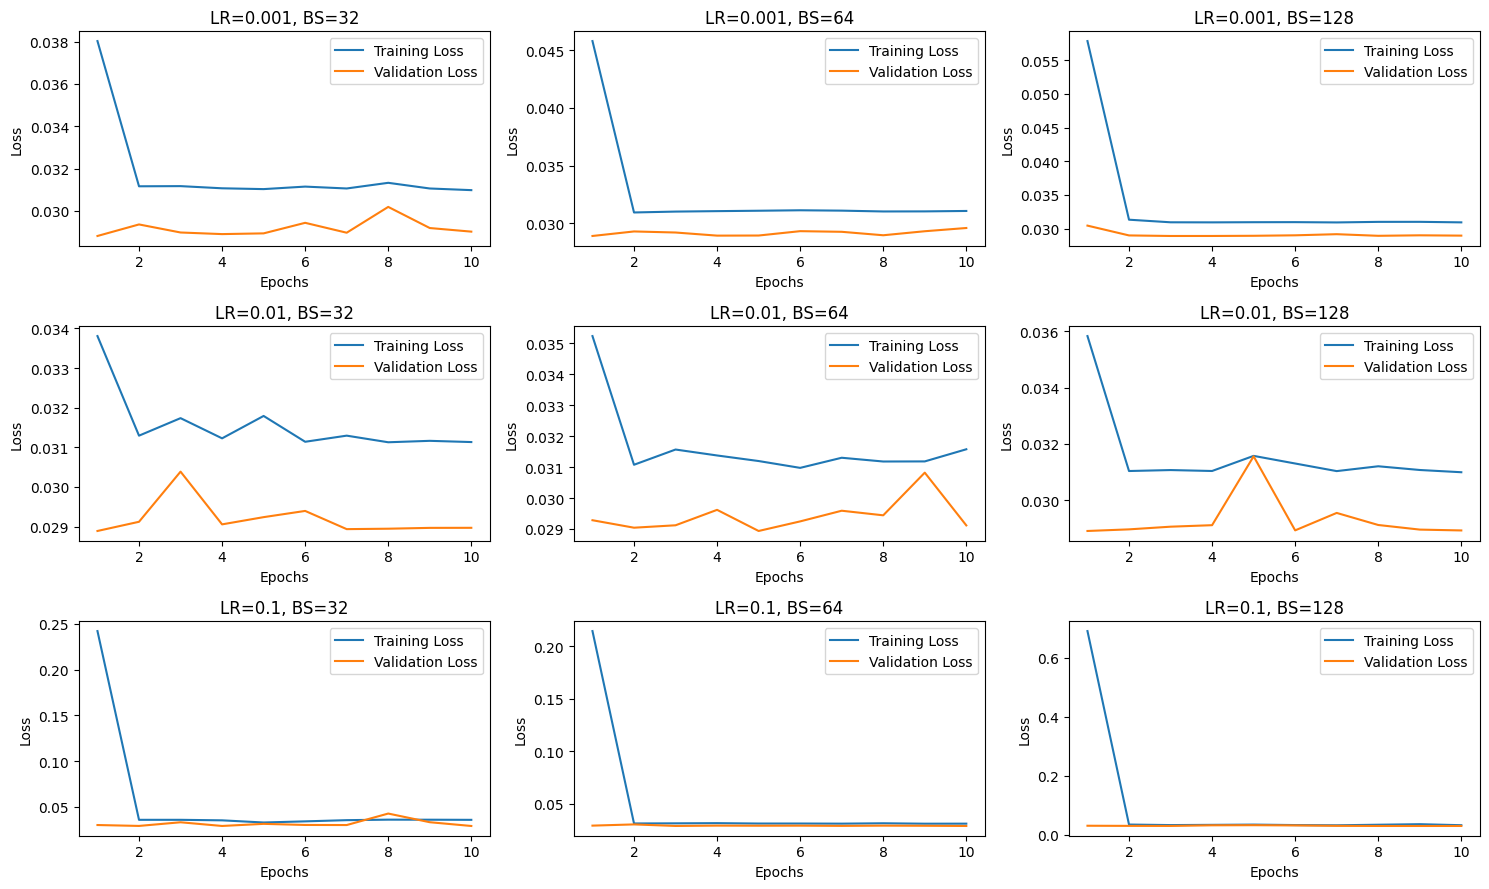

In [11]:
results = []
file_path = 'dataset.csv'
data = load_and_preprocess_data(file_path)

train_data, val_data, test_data = split_data(data)
seq_length = 10
train_sequences, train_labels = create_sequence_data(train_data, seq_length)
val_sequences, val_labels = create_sequence_data(val_data, seq_length)

input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
num_epochs = 10
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]


for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate: {lr}, batch size: {batch_size}")
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_dataset = TensorDataset(train_sequences, train_labels)
        val_dataset = TensorDataset(val_sequences, val_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

        experiment_results = {
            'lr': lr,
            'batch_size': batch_size,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        results.append(experiment_results)

        print("Training completed.\n")

torch.save(model.state_dict(), 'trained_model.pth')
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('trained_model.pth'))
test_sequences, test_labels = create_sequence_data(test_data, seq_length)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1)
test_loss = test_model(model, test_loader)
print(f'Test Loss: {test_loss}')  

pred_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
pred_model.load_state_dict(torch.load('trained_model.pth'))
pred_model.eval()

pred_data = pd.read_csv("dataset.csv")
pred_data['Date'] = pd.to_datetime(pred_data['Date'])

target_month = pd.to_datetime("2023-08")
target_index = (pred_data['Date'].dt.to_period('M') == target_month.to_period('M')).idxmax()

with torch.no_grad():
    test_inputs, test_labels = test_sequences, test_labels
    test_outputs = pred_model(test_inputs.float())

    target_index = min(max(target_index, 0), len(test_outputs) - 1)

    predicted_value = test_outputs[target_index].item()
    true_value = test_labels[target_index].item()

    print(f'Predicted Value for {target_month}: {predicted_value}')
    print(f'True Value for {target_month}: {true_value}')


show_graphs(results, num_epochs)

Исходя из полученных результатов мы можем наблюдать незначительные потери, а так же что при комбинациях learning rate = 0,1 и batch size = 64 и 128 модель ведёт себя наиболее стабильно и различия между потерями минимальны в отличие от остальных комбинаций. Так же хотелось бы отметить что предсказанные и настоящие значения довольно близки.